In [1]:
from src.sift import *
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Estimating the fundamental Matrix
8 points algorithm

7 points algorithm (work in progress)

Robust estimation (work in progress)


## 8-points Algorithm:

In [2]:
def FundamentalM(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]

    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F_ = V[-1].reshape((3,3))

    U,S,V = np.linalg.svd(F_)
    
    S[-1]=0
    
    F = (U.dot(np.diag(S))).dot(V)
       
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
      
    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# 7-points Algorithm

In [3]:
class mindetF:
    def __init__(self,F1,F2):
        self.F1=F1
        self.F2=F2
    def get_F(self,alpha):
        return alpha*self.F1+(1-alpha)*self.F2
        
    def get_det(self,alpha):
        return np.abs(np.linalg.det(self.get_F(alpha)))
    
    def solve(self):
        minimum = optimize.fmin(self.get_det, 0.9,full_output=False,disp=False)
        #if minimum[0]>=1e-5:print('F7 min greater than 1e-5')
        return self.get_F(minimum[0])

In [4]:
from scipy import optimize

def FundamentalM7pts(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]


    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F1 = V[-1].reshape((3,3))
    
    F2 = V[-2].reshape((3,3))
    
    f = mindetF(F1,F2)
    
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
    
   

    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# Hartley's normalization

In [5]:
class HartleysNorm:
    def __init__(self,pairs):
        self.pairs=pairs
        self.Tl = self.get_T(hmg(pairs[0][:,:2]))
        self.Tr = self.get_T(hmg(pairs[1][:,:2]))
        self.norm_pairs = hmg(pairs[0][:,:2]).dot(self.Tl),hmg(pairs[1][:,:2]).dot(self.Tr)
        
    def denormalize(self,F):
        return ((self.Tl.T).dot(F)).dot(self.Tr)
    
    def get_T(self,data):
        ml = data

        n = data.shape[0]

        ml_ = np.mean(ml,axis=0)

        sl = np.sqrt(np.sum((ml - ml_)**2)/(2*n))

        return np.array([[1/sl,0,(-1/sl)*ml_[0]],[0,1/sl,(-1/sl)*ml_[1]],[0,0,1]])


# Robust Estimation

In [6]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC2(pairs,min_pts=4,p=0.1,P=.99,th=100,type_='affine',max_it=50000):
    print("Starting RANSAC:")
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    best_fit=0

    for i in range(S):
        if p>0.9:
            break
            
        if type_=='affine':
            w,e,x1,x2 = Affine(pairs,min_pts)
        if type_ == 'F':
            w,e,x1,x2 = FundamentalM(pairs,min_pts,norm=False)
        else:
            w,e,x1,x2 = Homography(pairs,min_pts)

        inliers = np.sum(e<th**2)
        

        if best_fit<inliers:
            best_fit = inliers
            best_w = w
            best_e = np.mean(e)
            best_x1 = x1
            best_x2 = x2
            idx = e<th**2          
            p = best_fit/pairs[0].shape[0]
            print('Iteration: {}'.format(i))
            print(np.mean(e),p,best_fit,pairs[0].shape[0])         
            S += np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
        
        if i>max_it:
            break

    best_x1 = x1
    best_x2 = x2
    print('RANSAC error: {}'.format(best_e))

    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    elif type_=='F':
        H = np.reshape(best_w,(3,3))
    else:
        H = np.reshape(best_w,(3,3))

    return H,idx

# Helper functions

In [7]:
def hmg(x):
    n = x.shape[0]
    ones = np.ones(n)
    return np.vstack((x.T,ones)).T

In [8]:
def F_geomError(pairs,F):
    
    e1 = (F.dot(hmg(pairs[1][:,:2]).T)).T
    
    e2 = ((hmg(pairs[0][:,:2])).dot(F))

    d1 = np.sum(e1*hmg(pairs[0][:,:2]),axis=1)/np.sqrt(e1[:,0]**2+e1[:,1]**2)
    
    d2 = np.sum(e2*hmg(pairs[1][:,:2]),axis=1)/np.sqrt(e2[:,0]**2+e2[:,1]**2)
        
    return ((d1**2+d2**2)).T



In [9]:
def get_epipoles(F):
    U,S,V = np.linalg.svd(F)
    el = U[-1]
    er = V[-1]
    return el,er

In [10]:
def plot_epipoles(im1,pairs,F,idx,side='left'):
    img1 = im1.img1_
    
    pairs1 = (pairs[0][idx],pairs[1][idx])
    
    l = (F.dot(hmg(pairs1[1][:,:2]).T)).T
    
    if side=='right':
        pairs1 = (pairs[1][idx],pairs[0][idx])
        l = (F.T.dot(hmg(pairs1[1][:,:2]).T)).T
        
    num =  pairs1[0].shape[0]

    H,W = img1.shape

    l = l[:,[1,2]]/l[:,0][:,np.newaxis]

    x = np.arange(W)
    lines = []
    for i in range(num):
        y = -l[i,0]*x -l[i,1]
        keep = (y<H-1)&(y>0)
        lines.append((x[keep],y[keep]))

    plt.imshow(img1,**{'cmap':'gray'})

    for i in range(num):
        plt.scatter(pairs1[0][i,1],pairs1[0][i,0],c='red',s=1)
        plt.plot(lines[i][0],lines[i][1],**{'linestyle':'-','linewidth':0.5})
    plt.show()

# Examples/tests

## House

In [14]:
%%capture
im1 = sift(os.path.abspath('img/house/house22.jpg'),N=3,Red=2,s=5,sig=1.6,RANSAC_th=50,RANSAC_p=0.2)
im4 = sift(os.path.abspath('img/house/house23.jpg'),N=3,Red=2,s=5,sig=1.6,RANSAC_th=50,RANSAC_p=0.2)

im1==im4

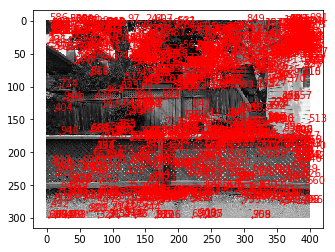

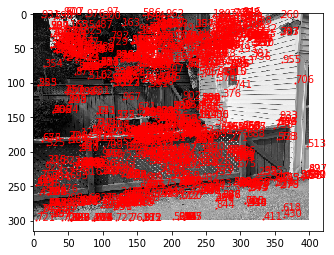

In [15]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 0
22913.695795862608 0.01017293997965412 10 983
Iteration: 3
115989.40707241594 0.011190233977619531 11 983
Iteration: 5
115787.61586178315 0.012207527975584944 12 983
Iteration: 6
41739.0963949753 0.017293997965412006 17 983
Iteration: 9
73696.7342966127 0.018311291963377416 18 983
Iteration: 10
16193.295673653476 0.023397761953204477 23 983
Iteration: 22
45226.37379320363 0.029501525940996948 29 983
Iteration: 32
28780.462739694856 0.04984740590030519 49 983
Iteration: 132
13630.035720134316 0.12919633774160733 127 983
Iteration: 607
13614.956325644254 0.19125127161749747 188 983
RANSAC error: 13614.956325644254


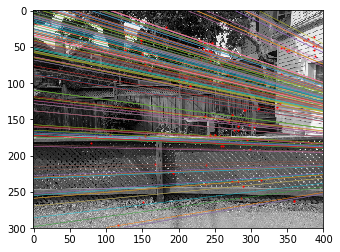

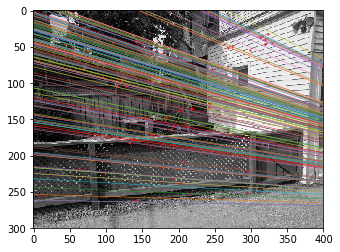

In [18]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=5,type_='F',max_it=1000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

## Pepsi:

In [19]:
%%capture
im1 = sift(os.path.abspath('img/pepsi1.jpg'),peak_th=0.03,crt=0.8,N=3,Red=2,s=5,sig=1.5,RANSAC_th=50)
im4 = sift(os.path.abspath('img/pepsi2.jpg'),peak_th=0.03,crt=0.8,N=3,Red=2,s=5,sig=1.5,RANSAC_th=50)

im1==im4

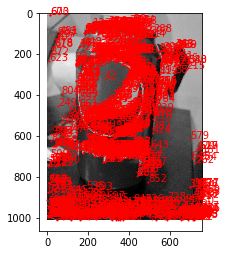

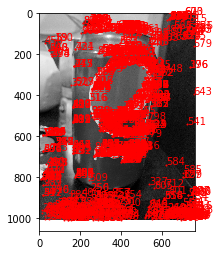

In [20]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 0
277764.15218504966 0.013555787278415016 13 959
Iteration: 3
187761.90658209755 0.017726798748696558 17 959
Iteration: 10
660335.2893260607 0.03232533889468196 31 959
Iteration: 50
161629.24196192942 0.040667361835245046 39 959
Iteration: 151
183524.30616967994 0.045881126173096975 44 959
Iteration: 1322
266565.4103865409 0.04692387904066736 45 959
Iteration: 1489
244842.72105662496 0.047966631908237745 46 959
Iteration: 1758
182201.17336257978 0.06256517205422316 60 959
Iteration: 2314
162958.36872819441 0.06569343065693431 63 959
Iteration: 2729
137538.11873574997 0.072992700729927 70 959
Iteration: 3784
167483.20452061712 0.08237747653806048 79 959
RANSAC error: 167483.20452061712


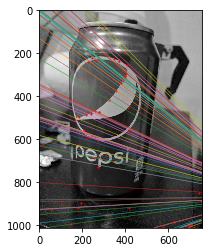

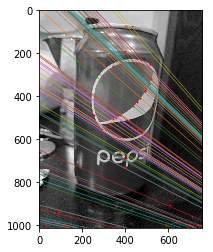

In [25]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=15,type_='F',max_it=5000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

## Uoft:

In [33]:
%%capture
im1 = sift(os.path.abspath('img/uoft6.jpg'),peak_th=0.03,crt=0.5,N=2,Red=3,s=5,sig=1.5,RANSAC_th=50)
im4 = sift(os.path.abspath('img/uoft4.jpg'),peak_th=0.03,crt=0.5,N=2,Red=3,s=5,sig=1.5,RANSAC_th=50)

im1==im4

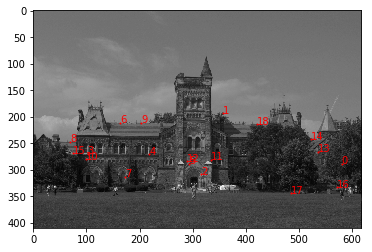

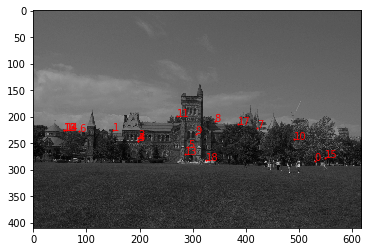

In [34]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 1
103799.28989069515 0.09090909090909091 2 22
Iteration: 11
39369.89204399995 0.13636363636363635 3 22
Iteration: 178
39118.88431833598 0.22727272727272727 5 22
Iteration: 423
54860.941157137466 0.36363636363636365 8 22
RANSAC error: 54860.941157137466


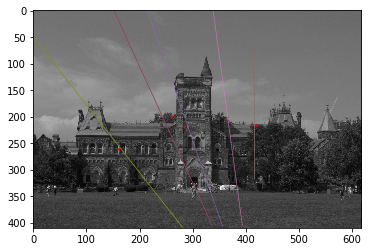

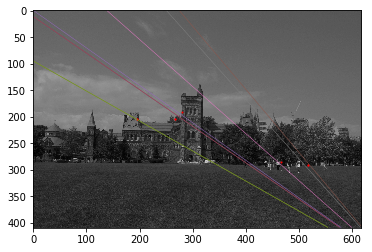

In [32]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=20,type_='F',max_it=5000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

# Work in progress:

In [ ]:
def computeE(el):
    zeros = np.zeros((3,3))
    e = np.array([[0,-el[2],el[1]],[el[2],0,-el[0]],[-el[1],el[0],0]])
    e1 = np.hstack([e,zeros,zeros])
    e2 = np.hstack([zeros,e,zeros])
    e3 = np.hstack([zeros,zeros,e])
    return np.vstack((e1,e2,e3))

#284

In [ ]:
def computeA(pairs):
    x1 = pairs[0][:,0]
    y1 = pairs[0][:,1]

    x2 = pairs[1][:,0]
    y2 = pairs[1][:,1]


    return np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape))).T


In [ ]:
def AlgError(el):
    r = 8
    A = computeA(pairs)
    
    E = computeE(el)

    U,S,V = np.linalg.svd(E)

    U_ = U[:,:r]

    _,_,V1 = np.linalg.svd(A.dot(U_))
    x_ = V1[-1]

    F_ = (U_.dot(x_))
    
    return A*F_[np.newaxis,:]


In [ ]:
def Jacobian(fun,x0,step):
    delta = np.zeros(x0.shape[0])    
    grad = np.zeros((9,9))
    for i in np.arange(x0.shape[0]):
        for j in np.arange(x0.shape[0]):
        delta[i] = step
        x2 = x0 + delta
        x1 = x0 - delta
        increment2 = fun(x2)
        increment1 = fun(x1)
        grad[i,j]=(increment2-increment1)/(2*step)
        delta[i] -= step  

    return np.array(grad)